In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

/home/rahul/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train=pd.read_csv("/home/rahul/machine learning/mnist kaggle/train.csv")

In [3]:
images=X_train.iloc[:,1:].values
images=images.astype(np.float)

In [4]:
labels_flat = X_train.iloc[:,0].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

In [5]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [6]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [7]:
images = np.multiply(images, 1.0 / 255.0)
image_size = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

In [8]:
def create_placeholders(image_size,image_count):
    X=tf.placeholder(shape=[None,image_size],dtype=np.float32)
    Y=tf.placeholder(shape=[None,image_count],dtype=np.float32)
    return X,Y

In [9]:
def weights_initializer():
    W1=tf.get_variable("W1",[5,5,1,64],initializer=tf.contrib.layers.xavier_initializer())
    W2=tf.get_variable("W2",[5,5,64,128],initializer=tf.contrib.layers.xavier_initializer())
    W3=tf.get_variable("W3",[5,5,128,256],initializer=tf.contrib.layers.xavier_initializer())
    W4=tf.get_variable("W4",[3,3,256,256],initializer=tf.contrib.layers.xavier_initializer())
    W5=tf.get_variable("W5",[3,3,256,512],initializer=tf.contrib.layers.xavier_initializer())
    W6=tf.get_variable("W6",[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
    
    parameters={"W1":W1,
                "W2":W2,
                "W3":W3,
                "W4":W4,
                "W5":W5,
                "W6":W6
               }
    return parameters

In [10]:
def forward_propagation(X,parameters):
    X1=tf.reshape(X,[-1,28,28,1])
    W1=parameters['W1']
    W2=parameters['W2']
    W3=parameters['W3']
    W4=parameters['W4']
    W5=parameters['W5']
    W6=parameters['W6']
    #1st layer convnet
    P6=tf.pad(X1,[[0,0],[2,2],[2,2],[0,0]],"CONSTANT")
    C1=tf.nn.conv2d(filter=W1,input=P6,padding="VALID",strides=[1,1,1,1])
    R1=tf.nn.relu(C1)
    #2nd layer convnet
    P1=tf.pad(R1,[[0,0],[2,2],[2,2],[0,0]],"CONSTANT")
    C2=tf.nn.conv2d(filter=W2,input=P1,strides=[1,1,1,1],padding="VALID")
    R2=tf.nn.relu(C2)
    M1=tf.nn.max_pool(R2,strides=[1,2,2,1],ksize=[1,1,1,1],padding="SAME")
    #3rd and 4rth layer convnet
    P2=tf.pad(M1,[[0,0],[2,2],[2,2],[0,0]],"CONSTANT")
    C3=tf.nn.conv2d(filter=W3,input=P2,strides=[1,1,1,1],padding="VALID")
    P3=tf.pad(C3,[[0,0],[1,1],[1,1],[0,0]],"CONSTANT")
    C4=tf.nn.conv2d(filter=W4,input=P3,strides=[1,1,1,1],padding="VALID")
    R3=tf.nn.relu(C4)
    M2=tf.nn.max_pool(R3,strides=[1,2,2,1],ksize=[1,1,1,1],padding="SAME")
    D1=tf.nn.dropout(M2,keep_prob=0.2)
    #5th layer convnet
    P4=tf.pad(D1,[[0,0],[1,1],[1,1],[0,0]],"CONSTANT")
    C5=tf.nn.conv2d(strides=[1,1,1,1],input=P4,filter=W5,padding="VALID")
    R4=tf.nn.relu(C5)
    D2=tf.nn.dropout(R4,keep_prob=0.2)
    #6th layer convnet
    P5=tf.pad(D2,[[0,0],[1,1],[1,1],[0,0]],"CONSTANT")
    C6=tf.nn.conv2d(strides=[1,1,1,1],input=P5,padding="VALID",filter=W6)
    R5=tf.nn.relu(C6)
    M3=tf.nn.max_pool(R5,strides=[1,2,2,1],ksize=[1,1,1,1],padding="SAME")
    D3=tf.nn.dropout(M3,keep_prob=0.5)
    #fully connected layer 1
    P3=tf.contrib.layers.flatten(D3)
    FC1=tf.contrib.layers.fully_connected(P3,num_outputs=2048,activation_fn=tf.nn.relu)
    #Fully connected layer 2
    FC2=tf.contrib.layers.fully_connected(FC1,num_outputs=10,activation_fn=tf.nn.softmax)
    return FC2

In [11]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.keras.backend.categorical_crossentropy(target=Y,output=Z3))
    return cost

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 36, seed = 0):
    
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    num_complete_minibatches = math.floor(m/mini_batch_size)  
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def model(X_train,Y_train,learning_rate=0.001,batch_size=36,print_cost=True,epochs=100):
    image_size=X_train.shape[1]
    image_count=Y_train.shape[1]
    m=X_train.shape[0]
    costs=[]
    X,Y=create_placeholders(image_size,image_count)
    parameters=weights_initializer()
    Z3=forward_propagation(X,parameters)
    cost=compute_cost(Z3,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for i in range(epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / batch_size)
            minibatches = random_mini_batches(X_train, Y_train, batch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and i % 5 == 0:
                print ("Cost after epoch %i: %f" % (i, minibatch_cost))
            if print_cost == True and i % 1 == 0:
                costs.append(minibatch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
        test_images = pd.read_csv('/home/rahul/machine learning/mnist kaggle/test.csv').values
        test_images = test_images.astype(np.float)
        test_images = np.multiply(test_images, 1.0 / 255.0)
        print('test_images({0[0]},{0[1]})'.format(test_images.shape))
        predict=tf.argmax(Z3,1)
        predicted_lables = np.zeros(test_images.shape[0])
        for i in range(0,test_images.shape[0]//64):
            predicted_lables[i*64 : (i+1)*64] = predict.eval(feed_dict={X: test_images[i*64 : (i+1)*64]})
        np.savetxt('submission3.csv', 
        np.c_[range(1,len(test_images)+1),predicted_lables], 
        delimiter=',', 
        header = 'ImageId,Label', 
        comments = '', 
        fmt='%d')
        return train_accuracy,parameters
    

Cost after epoch 0: 0.042839
Cost after epoch 5: 0.008335
Cost after epoch 10: 0.003693
Cost after epoch 15: 0.003372
Cost after epoch 20: 0.001814
Cost after epoch 25: 0.002607
Cost after epoch 30: 0.001812
Cost after epoch 35: 0.000962
Cost after epoch 40: 0.001874
Cost after epoch 45: 0.001321
Cost after epoch 50: 0.002291
Cost after epoch 55: 0.002638
Cost after epoch 60: 0.001481
Cost after epoch 65: 0.004458
Cost after epoch 70: 0.003803
Cost after epoch 75: 0.003283
Cost after epoch 80: 0.001869
Cost after epoch 85: 0.002074
Cost after epoch 90: 0.002102
Cost after epoch 95: 0.014772


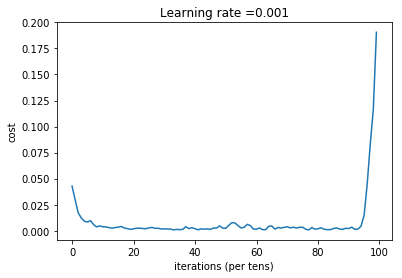

Tensor("Mean_1:0", shape=(), dtype=float32)


In [ ]:
 _, parameters = model(images,labels)